# Generating in silico data

In [1]:
from yeastdnnexplorer.probability_models.relation_classes import And, Or
from yeastdnnexplorer.probability_models.generate_data import (generate_gene_population, 
                                                               generate_binding_effects,
                                                               generate_pvalues,
                                                               generate_perturbation_effects,
                                                               perturbation_effect_adjustment_function_with_tf_relationships,
                                                               perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic)

import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)  # For CPU
torch.cuda.manual_seed_all(42)  # For all CUDA devices


Matplotlib is building the font cache; this may take a moment.


## Step 1:

The first step is to generate a gene population, or set of gene populations.
A gene population is simply a class that stores a 1D tensor called `labels`.
`labels` is a boolean vector where 1 means the gene is part of the bound group
(a gene which is both bound and responsive to the TF) while 0 means the gene is
part of the background or unbound group. The length of `labels` is the number of
genes in the population, and the index should be considered the unique gene
identifier. In other words, the indicies should never change.

In [2]:
n_genes = 1000
bound = [0.1, 0.15, 0.2, 0.25, 0.3]
n_sample = [1, 1, 2, 2, 4]

# this will be a list of length 10 with a GenePopulation object in each element
gene_populations_list = []
for bound_proportion, n_draws in zip(bound, n_sample):
    for _ in range(n_draws):
        gene_populations_list.append(generate_gene_population(n_genes, bound_proportion))


## Step 2:

The second step is to generate binding data from the gene population(s).

In [3]:
# Generate binding data for each gene population
binding_effect_list = [generate_binding_effects(gene_population)
                     for gene_population in gene_populations_list]


# Calculate p-values for binding data
binding_pvalue_list = [generate_pvalues(binding_data) for binding_data in binding_effect_list]

binding_data_combined = [torch.stack((gene_population.labels, binding_effect, binding_pval), dim=1)
                         for gene_population, binding_effect, binding_pval
                         in zip (gene_populations_list, binding_effect_list, binding_pvalue_list)]

# Stack along a new dimension (dim=1) to create a tensor of shape [num_genes, num_TFs, 3]
binding_data_tensor = torch.stack(binding_data_combined, dim=1)

# Verify the shape
print("Shape of the binding data tensor:", binding_data_tensor.shape)


Shape of the binding data tensor: torch.Size([1000, 10, 3])


## Step 3: Generate perturbation data.

It is important to understand that there are four possible ways we provide for you to generate perturbation data.
1. No Mean Adjustment
2. Standard Mean Adjustment
3. Mean adjustment dependent on all TFs bound to gene in question
4. Mean adjustment dependent on binary relationships between bound and unbound TFs to gene in question.

### Method 1: Generating perturbation data with no mean adjustment

If you don't pass in a value for `max_mean_adjustment` to `generate_perturbation_effects` it will default to zero, meaning the means of the perturbation effects will not be adjusted in any way and will all be equal to `bound_mean` (deault is 3.0) for bound TF-gene pairs and `unbound_mean` (default is 0.0) for unbound TF-gene pairs.

In [4]:
# See `generate_perturbation_effects()` in the help or the documentation for more details.
perturbation_effects_list_no_mean_adjustment = [generate_perturbation_effects(binding_data_tensor[:, tf_index, :].unsqueeze(1), tf_index=0) 
                                                        for tf_index in range(sum(n_sample))]
perturbation_pvalue_list_no_mean_adjustment = [generate_pvalues(perturbation_effects) for perturbation_effects in perturbation_effects_list_no_mean_adjustment]

### Method 2: Generating perturbation data with a simple mean adjustment
If you do pass in a nonzero value for `max_mean_adjustment`, the means of bound gene-TF pairs will be adjusted by up to a maximum of `max_mean_adjustment`. Note that instead of passing in one column (corresponding to one TF) of the binding data tensor at a time, we instead pass in the entire binding data tensor at once. This syntactic difference is just a result of how our mean adjustment functions requires the entire matrix of all genes and TFs as opposed to being able to operate on one column at once. Using this data generation method, we adust the mean of any TF that is bound to a gene.

In [5]:
# if you want to modify the default mean for bound genes, you can pass in the 'bound_mean' parameter
perturbation_effects_list_normal_mean_adjustment = generate_perturbation_effects(
    binding_data_tensor, 
    max_mean_adjustment=10.0
)

# since the p-value generation function operates on one column at a time, we must iterate over the columns of our perturb effects
# list and generate p-values for each column
perturbation_effects_list_normal_mean_adjustment_pvalues = torch.zeros_like(perturbation_effects_list_normal_mean_adjustment)
for col_idx in range(perturbation_effects_list_normal_mean_adjustment.shape[1]):
    col = perturbation_effects_list_normal_mean_adjustment[:, col_idx]
    col_pvals = generate_pvalues(col)
    perturbation_effects_list_normal_mean_adjustment_pvalues[:, col_idx] = col_pvals

### Method 3: Generating Perturbation Data with a mean adjustment dependent on which TFs are bound to gene
You are also able to specify a dictionary of TF relationships. Passing in this dictionary in combination with using our `perturbation_effect_adjustment_function_with_tf_relationships` mean adjustment function alows for you to only adjust the means of perturbation effects if the TF in the TF-gene pair in question is bound AND all other TFs associated with that TF are bound to the same gene. To associate a TF with another TF, put its index in the list of TFs corresponding to the other TF's index in the tf_relationships dictionary.


In [6]:
# define our dictionary of TF relationships
# For each gene, if TF 0 is bound, then we only adjust its mean if TF 1 is also bound
# similarly, if TF 7 is bound, we still only adjust its mean if TFs 1 and 4 are bound
tf_relationships = {
    0: [1],
    1: [8],
    2: [5, 6],
    3: [4],
    4: [5],
    5: [9],
    6: [4],
    7: [1, 4],
    8: [6],
    9: [4],
}

perturbation_effects_list_dep_mean_adjustment = generate_perturbation_effects(
    binding_data_tensor, 
    tf_relationships=tf_relationships,
    adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships,
    max_mean_adjustment=10.0,
)
perturbation_effects_list_dep_mean_adjustment_pvalues = torch.zeros_like(perturbation_effects_list_dep_mean_adjustment)
for col_idx in range(perturbation_effects_list_dep_mean_adjustment.shape[1]):
    col = perturbation_effects_list_dep_mean_adjustment[:, col_idx]
    col_pvals = generate_pvalues(col)
    perturbation_effects_list_dep_mean_adjustment_pvalues[:, col_idx] = col_pvals

### Method 4: Generating Perturbation Data with a mean adjustment dependent on boolean relationships between TFs
(see the documentation in `yeastdnnexplorer/probability_models/relation_classes.py` for more information on `And()` and `Or()`) 

This is a more advanced version of method 3 where instead of only specifying direct dependencies you can specify logical relations that must be satisfied for a gene-TF pair's perturbation effect value to be adjusted. For example, in the below example we only adjust the mean of TF 3 for each gene if TF 3 is bound and (7 || 9) && (6 && 7) are bound. 

In [7]:
# note that Or(1,1) is used to enforce a unary contraint
tf_relationships_dict_boolean_logic = {
    0: [And(3, 4, 8), Or(3, 7), Or(1, 1)],
    1: [And(5, Or(7, 8))],
    2: [],
    3: [Or(7, 9), And(6, 7)],
    4: [And(1, 2)],
    5: [Or(0, 1, 2, 8, 9)],
    6: [And(0, Or(1, 2))],
    7: [Or(2, And(5, 6, 9))],
    8: [],
    9: [And(6, And(3, Or(0, 9)))],
}

perturbation_effects_list_boolean_logic = generate_perturbation_effects(
    binding_data_tensor, 
    adjustment_function=perturbation_effect_adjustment_function_with_tf_relationships_boolean_logic,
    tf_relationships=tf_relationships_dict_boolean_logic,
    max_mean_adjustment=10.0,
)
perturbation_effects_list_boolean_logic_pvalues = torch.zeros_like(perturbation_effects_list_boolean_logic)
for col_idx in range(perturbation_effects_list_boolean_logic.shape[1]):
    col = perturbation_effects_list_boolean_logic[:, col_idx]
    col_pvals = generate_pvalues(col)
    perturbation_effects_list_boolean_logic_pvalues[:, col_idx] = col_pvals

## Step 4: Assemble

The final step is to assemble the data into a single tensor. Here is one way.
The order of the matrix in the last dimension is:

1. bound/unbound label
1. binding effect
1. binding pvalue
1. perturbation effect
1. perturbation pvalue

For simplicity's sake, we will use the perturbation effect data we generated with no mean adjustment. However you can assemble the data using perturbation effect data generated from any of the 4 methods we covered above.

In [8]:
# Convert lists to tensors if they are not already
perturbation_effects_tensor = torch.stack(perturbation_effects_list_no_mean_adjustment, dim=1)
perturbation_pvalues_tensor = torch.stack(perturbation_pvalue_list_no_mean_adjustment, dim=1)

# Ensure perturbation data is reshaped to match [n_genes, n_tfs]
# This step might need adjustment based on the actual shapes of your tensors.
perturbation_effects_tensor = perturbation_effects_tensor.unsqueeze(-1)  # Adds an extra dimension for concatenation
perturbation_pvalues_tensor = perturbation_pvalues_tensor.unsqueeze(-1)  # Adds an extra dimension for concatenation

# Concatenate along the last dimension to form a [n_genes, n_tfs, 5] tensor
final_data_tensor = torch.cat((binding_data_tensor, perturbation_effects_tensor, perturbation_pvalues_tensor), dim=2)

# Verify the shape
print("Shape of the final data tensor:", final_data_tensor.shape)

Shape of the final data tensor: torch.Size([1000, 10, 5])


As an aside, I choose to structure the data this way by looking at the
result of strides, which describes how the data is stored in memory:

In [9]:
tensor_continuous = torch.empty(100, 1000, 3)
strides_continuous = tensor_continuous.stride()
print(strides_continuous)


tensor_continuous = torch.empty(1000, 100, 3)
strides_continuous = tensor_continuous.stride()
print(strides_continuous)

(3000, 3, 1)
(300, 3, 1)


## Sanity checks

Ensure that the generated data matches expectations.

### The bound/unbound ratios should match exactly the initial bound ratio

In [10]:
tolerance = 1e-5
are_equal = torch.isclose(
    torch.sum(final_data_tensor[:, :, 0] == 1, axis=0),
    torch.tensor([val * n_genes for val, count in zip(bound, n_sample) for _ in range(count)],
                 dtype=torch.long),
    atol=tolerance)

print(f"bound/nosie ratio is correct: {are_equal.all()}")

bound/nosie ratio is correct: True


### Binding effect distributions should match expectations




In [11]:
labels = final_data_tensor[:, :, 0].flatten()
unbound_binding = final_data_tensor[:, :, 1].flatten()[labels == 0]
bound_binding = final_data_tensor[:, :, 1].flatten()[labels == 1]

print(f"The unbound binding max is {unbound_binding.max()} and the min is {unbound_binding.min()}")
print(f"the unbound min is {unbound_binding.min()}")
print(f"the unbound mean is {unbound_binding.mean()} and the std is {unbound_binding.std()}")
print(f"The bound binding max is {bound_binding.max()} and the min is {bound_binding.min()}")
print(f"the bound min is {bound_binding.min()}")
print(f"the bound mean is {bound_binding.mean()} and the std is {bound_binding.std()}")

The unbound binding max is 13.157892227172852 and the min is 0.0
the unbound min is 0.0
the unbound mean is 0.3589712679386139 and the std is 1.1559306383132935
The bound binding max is 78.94734954833984 and the min is 0.1315789520740509
the bound min is 0.1315789520740509
the bound mean is 2.4840002059936523 and the std is 6.374814510345459


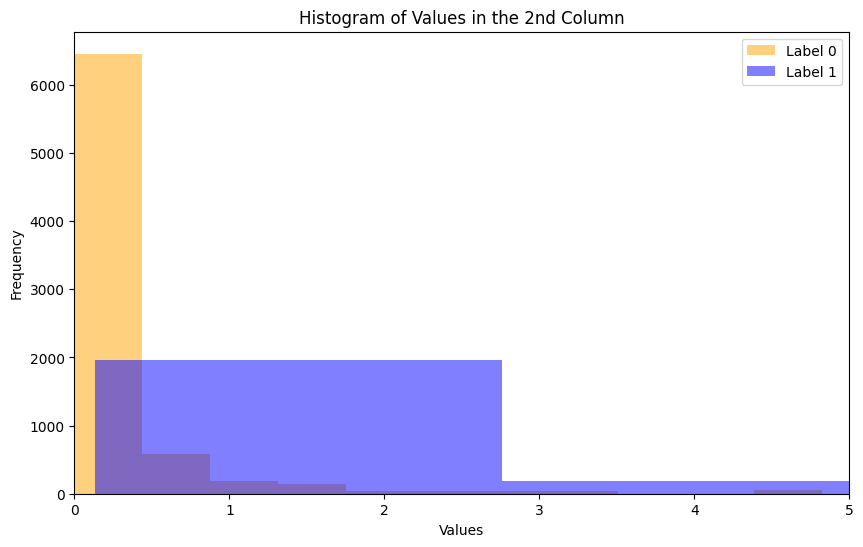

In [12]:

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(unbound_binding, bins=30, alpha=0.5, label='Label 0', color='orange')
plt.hist(bound_binding, bins=30, alpha=0.5, label='Label 1', color='blue')
plt.xlim(0,5)
plt.title('Histogram of Values in the 2nd Column')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Perturbation effect distribtuions should match expectations

In [13]:
unbound_perturbation = final_data_tensor[:, :, 3].flatten()[labels == 0]
bound_perturbation = final_data_tensor[:, :, 3].flatten()[labels == 1]

print(f"The unbound binding max is {unbound_perturbation.max()} and the min is {unbound_perturbation.min()}")
print(f"the unbound min is {unbound_perturbation.min()}")
print(f"the unbound mean is {unbound_perturbation.mean()} and the std is {unbound_perturbation.std()}")
print(f"The bound binding max is {bound_perturbation.max()} and the min is {bound_perturbation.min()}")
print(f"the bound min is {bound_perturbation.min()}")
print(f"the bound mean is {bound_perturbation.mean()} and the std is {bound_perturbation.std()}")

The unbound binding max is 3.423511505126953 and the min is -3.506139039993286
the unbound min is -3.506139039993286
the unbound mean is 0.010617653839290142 and the std is 0.988001823425293
The bound binding max is 6.107701301574707 and the min is -6.406703948974609
the bound min is -6.406703948974609
the bound mean is -0.011303802020847797 and the std is 3.136451482772827


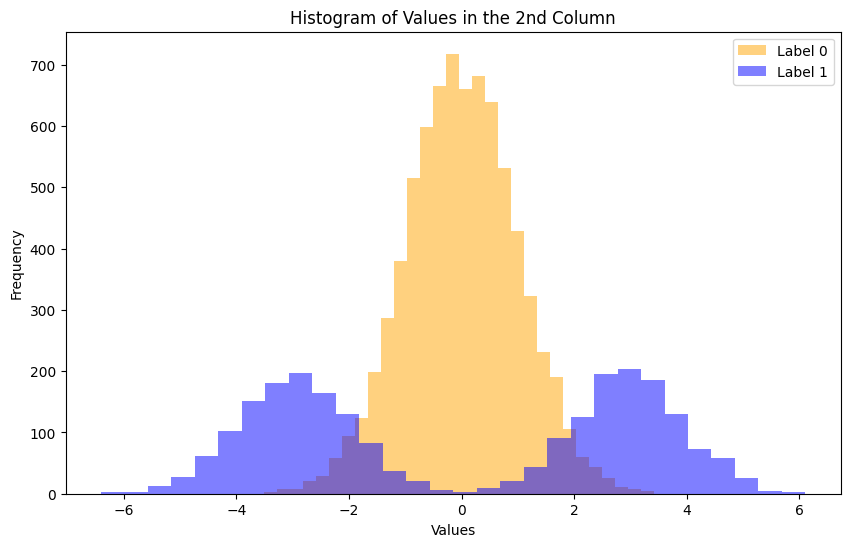

In [14]:
# Plotting
plt.figure(figsize=(10, 6))
plt.hist(unbound_perturbation, bins=30, alpha=0.5, label='Label 0', color='orange')
plt.hist(bound_perturbation, bins=30, alpha=0.5, label='Label 1', color='blue')
plt.title('Histogram of Values in the 2nd Column')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### The binding effects should be positively correlated with the perturbaiton effects

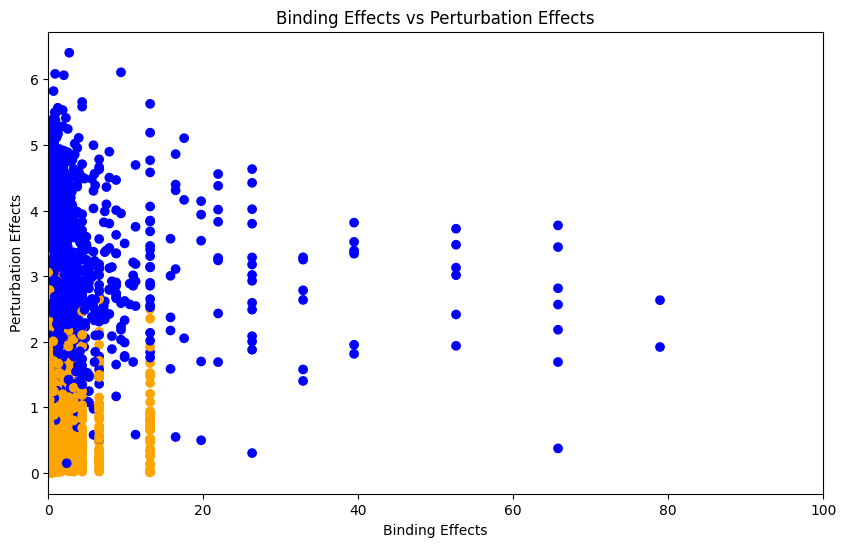

In [15]:
# plot the binding effects vs the perturbation effects
# color the points by the label
# make sure the labels are categorical
# label 0 should be blue while label 1 should be orange

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(final_data_tensor[:, :, 1].flatten(), final_data_tensor[:, :, 3].flatten().abs(), c=['orange' if x == 0 else 'blue' for x in labels])
plt.title('Binding Effects vs Perturbation Effects')
plt.xlabel('Binding Effects')
plt.ylabel('Perturbation Effects')
plt.xlim(0,100)
plt.show()

### Re-generate data with an explicit relationship between a give TF's binding and perturbation effects

In [16]:
# in this case, select the TF binding data that corresponds with the effect data
# which we wish to produce. use the .unsqueeze(1) method to add the TF dimension
# after selecting the TF
perturbation_effects_tf_influenced = generate_perturbation_effects(
    binding_data_tensor, 
    max_mean_adjustment=3.0, # try 0.1, 3.0, and 10.0
    bound_mean=5.0, # try 3.0, 5.0, or 10.0
    unbound_mean=0.0, # try adjusting this
)
perturbation_pvalue_tf_influenced = torch.zeros_like(perturbation_effects_tf_influenced)
for col_idx in range(perturbation_effects_tf_influenced.shape[1]):
    col = perturbation_effects_tf_influenced[:, col_idx]
    col_pvals = generate_pvalues(col)
    perturbation_pvalue_tf_influenced[:, col_idx] = col_pvals

perturbation_effects_tensor_tf_influened = perturbation_effects_tf_influenced.unsqueeze(-1)
perturbation_pvalues_tensor_tf_influenced = perturbation_pvalue_tf_influenced.unsqueeze(-1)

final_data_tensor_tf_influenced = torch.cat(
    (binding_data_tensor,
     perturbation_effects_tensor_tf_influened,
     perturbation_pvalues_tensor_tf_influenced), 
    dim=2)

# Verify the shape
print("Shape of the final data tensor:", final_data_tensor.shape)

Shape of the final data tensor: torch.Size([1000, 10, 5])


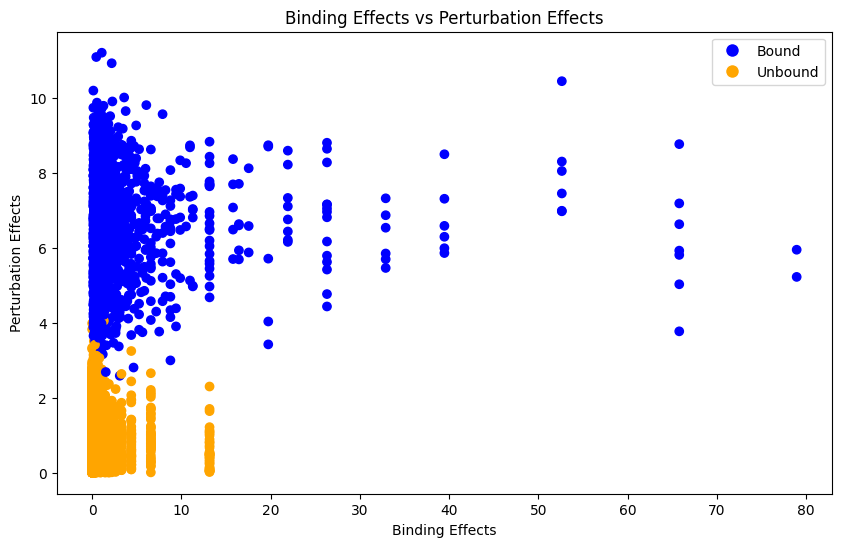

In [19]:
# Plotting. Note that the 'unbound' group effects are still range from 0 to 3

plt.figure(figsize=(10, 6))
plt.scatter(final_data_tensor_tf_influenced[:, :, 1].flatten(), final_data_tensor_tf_influenced[:, :, 3].flatten().abs(), c=['orange' if x == 0 else 'blue' for x in labels])
plt.title('Binding Effects vs Perturbation Effects')
plt.xlabel('Binding Effects')
plt.ylabel('Perturbation Effects')

legend_labels = ['Bound', 'Unbound']
colors = ['blue', 'orange']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]
plt.legend(legend_handles, legend_labels)

plt.show()